![](brain.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plot

# Réseau profond
## Mise en situation
Toujours salarié à la poste, préposé aux algorithmes de reconnaissance des codes postaux :)

90% c'est bien, tentons de faire mieux. Si passer d'un modèle logistique (1 couche) à un réseau de neurones tel qu'on la vu (2 couches) a grandement amélioré le modèle, est-ce qu'on ne pourrait pas faire encore mieux avec des couches en plus ?

## L'apprentissage profond
### Le principe
Le principe du _Deep Learning_, c'est d'entrer plus en profondeur dans l'apprentissage. Ajouter des couches de réseau notamment.

L'idée est la suivante - pour de la reconnaissance d'images : une première couche va détecter des patterns simples (des lignes par exemple), une seconde couche va détecter des patterns plus complexes qui combinent les premiers (des courbes par exemple), une troisième va mixer les précédents pour reconnaître des formes, etc...

### Définition formelle des couches
On appelle généralement les entrées la première couche, et la sortie la dernière couche.
Toutes les couches intermédiaires sont les couches cachées (_hidden layers_).

Autrement dit, dans le modèle précédent, il s'agissait sémantiquement parlant d'un réseau à trois couches : l'entrée (qui faisait 28x28), la couche intermédiaire (variable) et la sortie (taille 10).

### Dérivation et propagation du gradient
Le calcul de la dérivée va se faire comme précédemment. En gros, si on a une entrée $A_{n-1}$, des paramètres $W_{n}$ et $b_{n}$, et une fonction d'activation $a()$, on a:

* Passe en avant :

$Z_{n} = W_{n}.A_{n-1} + b_{n}\\
A_{n} = a(Z_{n})$

* Passe en arrière : avec en plus $dA_{n}$

$dZ_{n} = a'(Z_{n}) * dA_{n}\\
dW_{n} = dZ.A_{n-1}^T\\
db_{n} = \sum{dZ}\\
dA_{n-1} = W_{n}^T.dZ$

## Implémentation
Pour implémenter ça, on va procéder de la manière suivante:
1. On calcule les différents Z et A pour chaque couche. On gardera les résultats du calcul pour la marche arrière.
2. On revient en marche arrière, couche par couche aussi
3. On applique la descente de gradient

### Les fonctions
On commence par implémenter les différentes fonctions. On va aussi en faire un dictionnaire.

In [5]:
# Les différentes fonctions
def sigmoid(x) : return 1 / (1 + np.exp(-x))
def tanh(x): return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
def relu(x): return np.maximum(x, 0)

act_functions = {'sigmoid': sigmoid, 'tanh' : tanh, 'relu' : relu}

### Les dérivées

Et maintenant les dérivées de ces fonctions. On en fera aussi un dictionnaire.

In [3]:
# Leurs dérivées
def d_sigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

def d_tanh(x):
    t = tanh(x)
    return 1 - t**2

def d_relu(x):
    return x > 0

act_derivates = {'sigmoid': d_sigmoid, 'tanh' : d_tanh, 'relu' : d_relu}

### La passe en avant
On y va pour le calcul du modèle, et on commence par la passe en avant.

D'après les formules, on a besoin de calculer Z et A pour chaque couche, et au passage on aura besoin des Z et A correspondants lors de la marche arrière.

In [11]:

# Passe en avant : 1 couche - on utilise le dictionnaire de fonctions
def layer_forward_pass(X, W, b, activation):
    Z = np.dot(W, X) + b
    A = act_functions[activation](Z)
    return Z, A

# Passe en avant : toutes les couches
def model_forward_pass(X, activations, parameters):
    result = {}
    result['A0'] = X
    # Entrée de la première couche: X
    A = X
    for i in range(1, len(activations) + 1):
        # Pour chaque couche, une passe en avant. Les W et b viennent de parameters
        Z_next, A_next = layer_forward_pass(A, parameters['W' + str(i)], parameters['b' + str(i)], activations[i-1])
        result['Z' + str(i)] = Z_next
        result['A' + str(i)] = A_next
        A = A_next
    return result

### La passe en arrière
On va maintenant calculer tous les gradients à partir du gradient de A sur la couche dont on vient, ainsi que Z, A et W de la couche considérée.

In [12]:

# Passe en arrière : 1 couche - on utilise le dictionnaire de dérivées
def layer_backward_pass(dA, Z, A_prev, W, activation):
    dZ = dA * act_derivates[activation](Z)
    dW = np.dot(dZ, A_prev.T)
    db = np.sum(dZ, axis=1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    return dW, db, dA_prev

# Passe en arrière : toutes les couches
def model_backward_pass(dA_last, parameters, forward_pass_results, activations):
    gradients = {}
    dA = dA_last
    for i in range(len(activations), 0, -1):
        dW, db, dA_prev = layer_backward_pass(dA,
                                              forward_pass_results['Z' + str(i)],
                                              forward_pass_results['A' + str(i-1)],
                                              parameters['W' + str(i)],
                                              activations[i-1])
        gradients['dW' + str(i)] = dW
        gradients['db' + str(i)] = db
        dA = dA_prev
    return gradients

### Entrainement du modèle
Il ne reste plus qu'à faire la descente en elle-même.
* On initialise tous les W et tous les b
* On boucle 
  * On calcule tous les Z et tous les A
  * On calcule dA final
  * On remonte tous les dZ, dA, dW et dB
  * On descent les gradients dW et dB

In [13]:

def train_model(X, Y, layer_dimensions, layer_activations,
               learning_rate = 0.01, epochs = 10, batch_size = 64,
               show_cost = False):
    
    m = X.shape[1]
    #Nombre de couches - hors celle des entrées
    l = len(layer_dimensions)-1
    
    # Création de tous les paramètres
    # A chaque étape, W a pour dimensions "nb neurones de la couche" x "nb entrées"
    # Et b est un vecteur, une valeur par neurone
    parameters = {}
    for i in range(1, l+1):
        parameters['W' + str(i)] = np.random.randn(layer_dimensions[i], layer_dimensions[i-1]) * 0.01
        parameters['b' + str(i)] = np.zeros((layer_dimensions[i], 1))
    
    costs = []
    # Apprentissage
    for e in range(epochs):
        for s in range(0, m, batch_size):
            x_batch = X[:, s:s+batch_size]
            y_batch = Y[:, s:s+batch_size]
    
            # Passe en avant
            forward_pass_results = model_forward_pass(x_batch, layer_activations, parameters)
            
            # Calcul de la dérivée du coût par rapport au dernier A
            A_last = forward_pass_results['A' + str(l)]
            dA_last = -(np.divide(y_batch, A_last) - np.divide(1 - y_batch, 1 - A_last))/x_batch.shape[1]

            # Calcul des gradients - passe en arrière
            gradients = model_backward_pass(dA_last, parameters, forward_pass_results, layer_activations)
            
            # Descente de gradient
            for i in range(1, l+1):
                parameters['W' + str(i)] -= learning_rate * gradients['dW' + str(i)]
                parameters['b' + str(i)] -= learning_rate * gradients['db' + str(i)]
        
        # Un peu de debug
        model_result = model_forward_pass(X, layer_activations, parameters)['A' + str(l)]
        cost = np.squeeze(-np.sum(np.log(model_result) * Y + np.log(1 - model_result) * (1-Y))/m)
        costs.append(cost)
        if show_cost : print('Epoch #%i: %s' % (e+1, cost))
    return parameters, costs

## Retour à la mise en situation

### Chargement des données

On continue avec le dataset de Yann Le Cun http://yann.lecun.com/exdb/mnist/ (images 28x28, 60.000 données d'entrainement et 10.000 données de validation)

In [15]:
def load(file): 
    data = np.load(file)
    return data['x'], data['y']

x_train, y_train = load('data/d09_train_data.npz')
x_test , y_test  = load('data/d09_test_data.npz')

mus    = x_train.mean(axis = 0, keepdims = True)
sigmas = x_train.std (axis = 0, keepdims = True) + 1e-9

x_train_norm = (x_train-mus)/sigmas
x_test_norm  = (x_test -mus)/sigmas

y_train_mat = (y_train == np.arange(10)).astype(int)

Allez, c'est parti. On va essayer par exemple (au pif) "tanh 50 / sigmoid 25 / sigmoid 10" sur 30 époques.

Epoch #1: 2.30543242166822
Epoch #2: 0.8672230396771443
Epoch #3: 0.5402521350775323
Epoch #4: 0.4020369615764879
Epoch #5: 0.3275815333298787
Epoch #6: 0.27666591760091486
Epoch #7: 0.2396338458387329
Epoch #8: 0.21253026251026488
Epoch #9: 0.19252387304390495
Epoch #10: 0.17572010648636466
Epoch #11: 0.16278958540674465
Epoch #12: 0.1488421702617406
Epoch #13: 0.1365402813484844
Epoch #14: 0.12734935170992287
Epoch #15: 0.11824495832867164
Epoch #16: 0.11030037387666043
Epoch #17: 0.103274526001583
Epoch #18: 0.09714845430784734
Epoch #19: 0.0913995686033537
Epoch #20: 0.08535739959465743
Epoch #21: 0.08057645151848615
Epoch #22: 0.07478317718782729
Epoch #23: 0.07106743845405625
Epoch #24: 0.06712220945939042
Epoch #25: 0.06337991778373567
Epoch #26: 0.059884086943492086
Epoch #27: 0.057084094023103764
Epoch #28: 0.054317420381163925
Epoch #29: 0.05180229404945984
Epoch #30: 0.04877062957830094


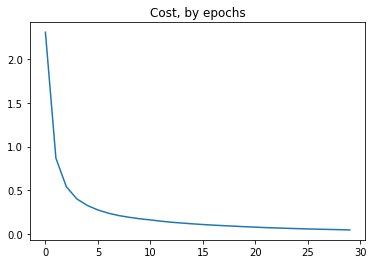

In [16]:
np.random.seed(0)
epochs = 30
activations = ['tanh', 'sigmoid', 'sigmoid']

params, costs = train_model(x_train_norm.T, y_train_mat.T, [28*28, 50, 25, 10], activations,
                            epochs = epochs, learning_rate = 0.1, show_cost = True)

plot.plot(range(epochs), costs)
plot.title('Cost, by epochs')
plot.show()

Sympa. On va voir le résultat maintenant

In [39]:
def accuracy(x, y, params, layer_activations):
    results = np.argmax(model_forward_pass(x, layer_activations, params)['A'+str(len(layer_activations))], axis = 0)
    return np.mean(results == y)

print('Accuracy on training set : %f%%' % (100*accuracy(x_train_norm.T, y_train.T, params, activations)))
print('Accuracy on test set : %f%%'     % (100*accuracy(x_test_norm.T , y_test.T , params, activations)))

Accuracy on training set : 99.618333%
Accuracy on test set : 95.160000%


<ipython-input-5-db26018beedf>:3: RuntimeWarning: overflow encountered in exp
  def tanh(x): return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
<ipython-input-5-db26018beedf>:3: RuntimeWarning: invalid value encountered in true_divide
  def tanh(x): return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))


**99.6%** au training !!!

Bon par contre *que* 95% au test.

Ca signifie un gros overfit puisqu'on a une grosse variance. On a plusieurs manière de traiter ça, on les verra plus tard, mais aussi il faut savoir que plus le modèle est complexe (nombre de couches, nombre de neurones), plus on est sujet à l'overfit : le modèle a toute la liberté qu'il souhaite pour essayer de coller aux données d'entrainement. On essaye un autre modèle "relu 50 / relu 25 / sigmoide 10" par exemple :

Epoch #1: 3.2195483867992793
Epoch #2: 2.0287953695902634
Epoch #3: 1.2126691928430533
Epoch #4: 0.8336738098191159
Epoch #5: 0.5623689268493152
Epoch #6: 0.4555980061721843
Epoch #7: 0.39161707515738664
Epoch #8: 0.3469891733366317
Epoch #9: 0.3138278944290432
Epoch #10: 0.2879912661898643
Epoch #11: 0.2670224230888944
Epoch #12: 0.24939292249481787
Epoch #13: 0.23433969160319695
Epoch #14: 0.221318233683586
Epoch #15: 0.2099040925033945
Epoch #16: 0.19943010551131396
Epoch #17: 0.1899812082312572
Epoch #18: 0.1814930746600185
Epoch #19: 0.17359656460343328
Epoch #20: 0.16625734854894347
Epoch #21: 0.15958209107379936
Epoch #22: 0.1532596114878994
Epoch #23: 0.14738682595420918
Epoch #24: 0.14180338078302335
Epoch #25: 0.13659951420139718
Epoch #26: 0.13155587558984533
Epoch #27: 0.12692951793706558
Epoch #28: 0.12238802168322196
Epoch #29: 0.11819243337864467
Epoch #30: 0.11416090553141027


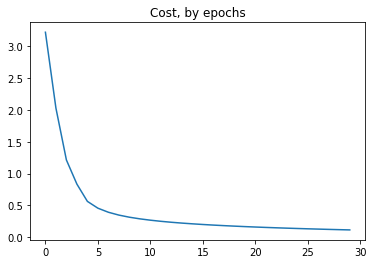

In [42]:
np.random.seed(0)
epochs = 30
activations = ['relu', 'relu', 'sigmoid']

params, costs = train_model(x_train_norm.T, y_train_mat.T, [28*28, 50, 25, 10], activations,
                            epochs = epochs, learning_rate = 0.01, show_cost = True)

plot.plot(range(epochs), costs)
plot.title('Cost, by epochs')
plot.show()

In [43]:
print('Accuracy on training set : %f%%' % (100*accuracy(x_train_norm.T, y_train.T, params, activations)))
print('Accuracy on test set : %f%%'     % (100*accuracy(x_test_norm.T , y_test.T , params, activations)))

Accuracy on training set : 98.576667%
Accuracy on test set : 96.910000%


<ipython-input-5-db26018beedf>:2: RuntimeWarning: overflow encountered in exp
  def sigmoid(x) : return 1 / (1 + np.exp(-x))


On fait *un poil* moins bien sur le jeu d'entrainement mais enfin c'est toujours du 98.57%, et on fait quasiment du 97% sur le jeu de test, ce qui est sensiblement mieux !

Voilà, donc un peu plus de biais mais un peu moins de variance sur ce modèle. Et si la métrique qu'on retient est la précision, alors le second modèle est un peu meilleur.


## Quelques remarques

### L'importance du jeu de dev
Quand on dit "le modèle avec deux ReLUs fonctionne mieux que celui avec tanh + sigmoid", c'est fortement biaisé : la vérité est que **sur le jeu de test qu'on a à disposition**, ce modèle fait mieux.

Autrement dit, on "entraîne" l'hyper-paramètre "structure du réseau" pour minimiser une fonction de coût (celle sur le jeu de test) !

Et de la même manière qu'on valide le résultat de l'entrainement sur des données inconnues, il faudrait faire pareil pour cet ajustement de structure.

En gros, il faudrait :
* un jeu d'entrainement comme le notre
* un jeu de dev, qui nous permet de mieux développer notre modèle : quelle est la meilleure structure, la meilleure régularisation, etc... une fois un modèle entraîné, on compare les performances avec un jeu de données dédié.
* un jeu de test, qui nous permet, une fois notre meilleur modèle trouvé, de regarder sa performance "globale".

### Extension du système
Pour intégrer une nouvelle fonction d'activation, rien de plus simple, il suffit d'avoir la fonction souhaitée et sa dérivée, et de les ajouter aux dictionnaires correspondants.

### Étapes suivantes
Il y a pas mal de choses supplémentaires à faire, pour limiter l'overfit par exemple (un peu de régulation) et des techniques avancées pour optimiser la convergence.